In [ ]:
import numpy as np
import matplotlib.pyplot as plt

eta = 0.1
T = 100
x, y = 1.0, 1.0  # starting point
xs, ys = [x], [y]

for _ in range(T):
    x, y = x - eta * y, y + eta * x  # GDA update
    xs.append(x); ys.append(y)

plt.plot(xs, ys, 'o-', markersize=3)
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.title("GDA on f(x,y)=xy")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal')
plt.show()


In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 50
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [4]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np


# Generate RX positions

distances_km = [0.5]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(120, 80),(45, 90), (75,75),(80,88), (65, 85),(130,75)]
angles = [(1, 90-(1e-3)), (60, 87), (120,84),(180,80), (240, 82),(300,80)]
# angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]
# angles = [(45, 90-(1e-3)), (220, 87), (75,85)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


TX0(m): [0. 0. 0.]
TX1(m): [ 3.06161699e-14  4.99999999e+02 -1.96201537e-02]

Satellite Pos [m]:
 [[ 1.67531075e-01  9.59784887e+00  5.50000000e+05]
 [ 2.49598339e+04  1.44105668e+04  5.49939990e+05]
 [ 5.00406602e+04 -2.88909887e+04  5.49758791e+05]
 [-1.77929524e-11 -9.68603215e+04  5.49322180e+05]
 [-6.68891070e+04 -3.86184439e+04  5.49569013e+05]
 [-8.38834990e+04  4.84301607e+04  5.49322180e+05]]

From TX0:
  SAT0: az=1.00°, el=90.00°, dist=550000.00 m, λ count ≈ 18333333.34
  SAT1: az=60.00°, el=87.00°, dist=550694.70 m, λ count ≈ 18356489.92
  SAT2: az=120.00°, el=84.00°, dist=552787.02 m, λ count ≈ 18426233.87
  SAT3: az=180.00°, el=80.00°, dist=557796.36 m, λ count ≈ 18593212.01
  SAT4: az=240.00°, el=82.00°, dist=554969.94 m, λ count ≈ 18498998.08
  SAT5: az=300.00°, el=80.00°, dist=557796.36 m, λ count ≈ 18593212.01

From TX1:
  SAT0: az=179.98°, el=89.95°, dist=550000.24 m, λ count ≈ 18333341.27
  SAT1: az=60.87°, el=87.03°, dist=550681.86 m, λ count ≈ 18356062.01
  SAT2: a

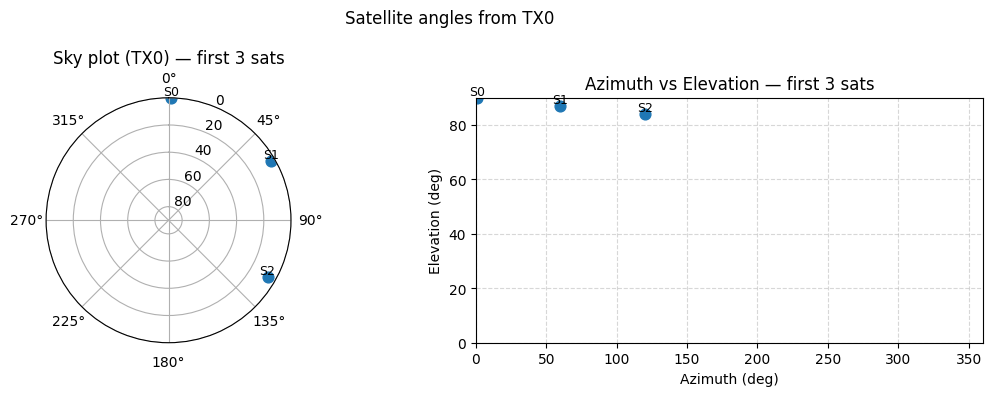

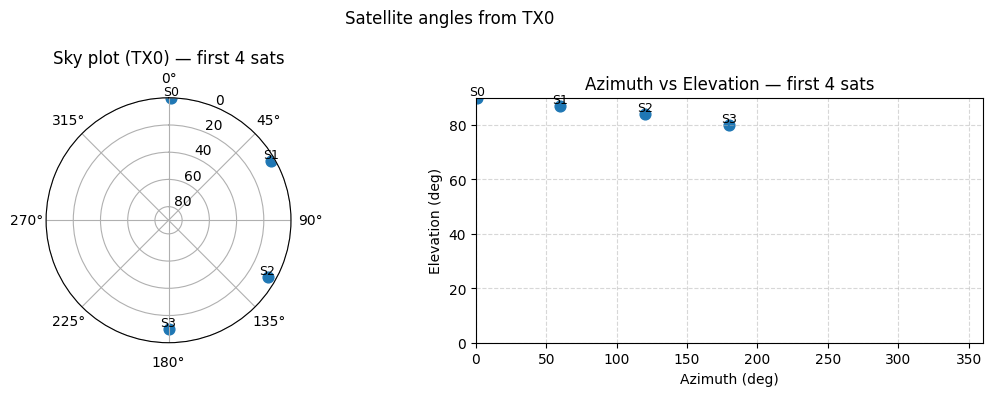

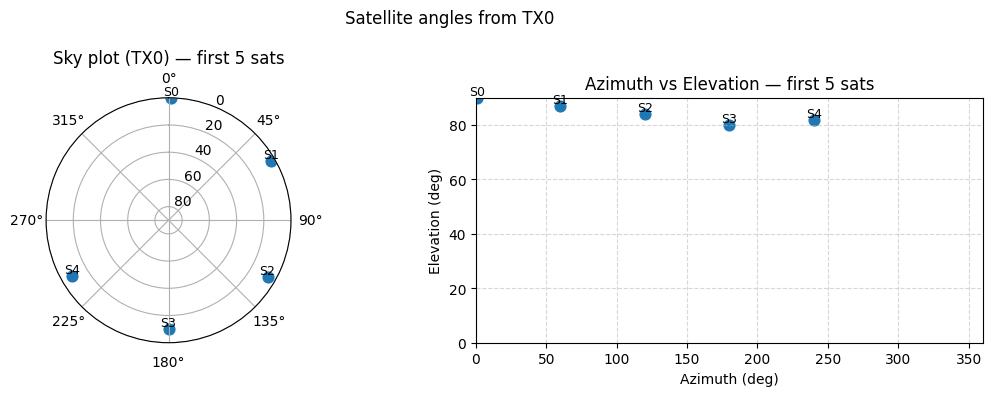

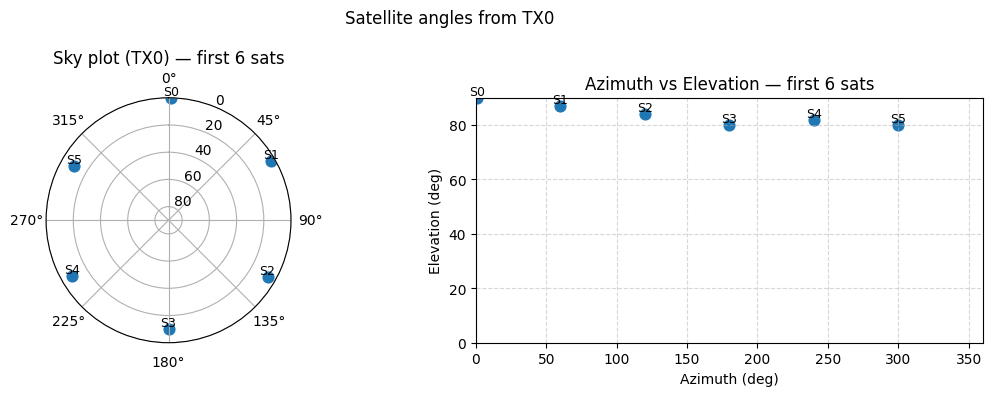

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Choose which ground TX viewpoint to use (0 = first one you printed)
tx_idx = 0  

def sats_az_el_for_k(k, tx_pos):
    az_list, el_list = [], []
    for j in range(k):
        az, el, dist, n_waves = compute_az_el_dist(sat_positions[j], tx_pos, frequency_hz)
        az_list.append(az)
        el_list.append(el)
    return np.array(az_list), np.array(el_list)

# Make four figures for k = 3,4,5,6
for k in [3, 4, 5, 6]:
    az, el = sats_az_el_for_k(k, gnd_positions[tx_idx])

    fig = plt.figure(figsize=(11, 4))

    # ---- (Left) Polar sky plot: radius = 90 - elevation (0 at zenith) ----
    ax1 = plt.subplot(1, 2, 1, projection='polar')
    theta = np.deg2rad(az)                 # azimuth in radians
    r = 90.0 - el                          # zenith angle
    sc = ax1.scatter(theta, r, s=60)
    # Annotate satellite indices
    for j in range(k):
        ax1.text(theta[j], r[j], f"S{j}", ha='center', va='bottom', fontsize=9)
    ax1.set_rlim(90, 0)                    # zenith at center
    ax1.set_theta_zero_location("N")       # 0° at North (up)
    ax1.set_theta_direction(-1)            # azimuth increasing clockwise
    ax1.set_title(f"Sky plot (TX{tx_idx}) — first {k} sats")

    # ---- (Right) Cartesian azimuth vs elevation ----
    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(az, el, s=60)
    for j in range(k):
        ax2.text(az[j], el[j], f"S{j}", ha='center', va='bottom', fontsize=9)
    ax2.set_xlim(0, 360)
    ax2.set_ylim(0, 90)
    ax2.set_xlabel("Azimuth (deg)")
    ax2.set_ylabel("Elevation (deg)")
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_title(f"Azimuth vs Elevation — first {k} sats")

    plt.suptitle(f"Satellite angles from TX{tx_idx}")
    plt.tight_layout()
    plt.show()


In [6]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np

def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = Scene()
    scene.frequency = frequency
    scene.synthetic_array = True

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at)
        rx_list.append(rx)

    tx.look_at(tx_look_at)  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all


jitc_llvm_init(): LLVM API initialization failed ..


In [7]:
import vsat_dish_3gpp
jam_rows =8
jam_cols = 8
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")




In [8]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t




In [9]:
a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])
a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])
H0 = collapse_channel(a_tx)
H1 = collapse_channel(a_jam)



N0 = noise_power_watt
P0 = Tx_power_watt
P1 = jam_power_watt


In [10]:
from minmax_solvers import solve_game_mirror_prox, solve_game_bestresp_Q0_then_Q1, solve_game_proxBR, solve_game_extragradient, solve_game_pdhg

In [ ]:
# Initialize jammer covariance with an equal-power PSD matrix (trace = P1)
n1 = H1.shape[1]
Q1_init = (P1 / n1) * np.eye(n1, dtype=complex)

# ---- Run the BR (water-filling on Q0) + inner updates on Q1 ----
# geometry='euclidean'  → Q1 uses Extragradient steps
# geometry='entropy'    → Q1 uses Mirror-Prox steps (entropy geometry)
# step_rule='fixed'     → fixed inner step size
# step_rule='adp'       → adaptive inner step size via backtracking (eta_init, eta_min/max, beta, gamma)
Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
    H0, H1, N0,
    P0=P0, P1=P1,
    max_outer=5000,         # maximum number of outer iterations
    tol=1e-6,               # stopping tolerance (uses errQ1 + residual)
    inner_Q1_steps=4,       # number of inner steps for Q1 per outer iteration
    geometry='entropy',     # 'euclidean' (EG) or 'entropy' (Mirror-Prox on Q1)
    step_rule='adp',        # 'fixed' or 'adp' (adaptive with backtracking)
    eta=0.5,                # used only when step_rule='fixed'
    eta_init=0.3,           # initial step size when step_rule='adp'
    eta_min=1e-2, eta_max=0.7,  # step size bounds for 'adp'
    beta=0.5, gamma=1.01,   # backtracking shrink/expand factors
    multi_stream=True,      # water-filling across multiple modes for Q0
    verbose=True,           # print progress every few iterations
    track_hist=True,        # record history curves in 'hist'
    Q1_init=Q1_init         # warm-start for jammer
)

import matplotlib.pyplot as plt
plt.plot(hist['J']); plt.title("Rate J"); plt.show()
plt.plot(hist['errQ1']); plt.title("errQ1"); plt.show()
plt.plot(hist['eta']); plt.title("eta evolution"); plt.show()

In [ ]:
Q0, Q1, hist = solve_game_proxBR(
    H0, H1, N0, P0, P1,
    rho=1e-2,                  # proximal regularization weight
    outer_steps=1000,          # maximum number of outer iterations
    outer_tol=1e-6,            # stopping tolerance for outer loop
    inner_max=200,             # maximum number of inner iterations (per BR update)
    inner_tol=1e-6,            # stopping tolerance for inner solver
    eta0_inner=0.5,            # initial step size for the inner updates
    beta=0.5, gamma=1.1,       # backtracking shrink/expand factors
    eta_min=1e-2, eta_max=1.0, # step size bounds for inner loop
    eta_probe=0.1,             # step size for residual evaluation (“thermometer”)
    min_outer=5,               # prevent early stopping before at least 5 iterations
    verbose=True,              # print progress to console
    track_hist=True            # record history (J, errors, residual, traces)
)



import matplotlib.pyplot as plt
plt.plot(hist['J']);        plt.title("J");         plt.show()
plt.plot(hist['errQ1']);    plt.title("errQ1");     plt.show()
plt.plot(hist['residual']); plt.title("residual");  plt.show()
plt.plot(hist['trQ1']);     plt.title("tr(Q1)");    plt.show()

In [ ]:
n1 = H1.shape[1]
Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

Q0_mp, Q1_mp, hist_mp = solve_game_mirror_prox(
    H0, H1, N0, P0, P1,
    steps=10000,              # maximum number of iterations
    eta=0.25,                 # step size (try values between 0.2–0.4)
    step_rule='adp',          # 'adp' = adaptive step size; use 'fixed' if unstable
    beta=0.3, gamma=1.03,     # shrink/expand factors for adaptive step size
    eta_min=1e-3, eta_max=1.0,# bounds for adaptive step size
    strong_reg=0.0,           # set to ~1e-3 if the solver becomes unstable
    Q0_init=None,             # optional initialization for desired signal covariance
    Q1_init=Q1_init,          # optional initialization for jammer covariance
    use_averaging=True,       # enable tail averaging for stability
    eta_probe=0.1,            # step size used for residual evaluation
    verbose=True,             # print iteration logs
    track_hist=True           # record history (objective, errors, residuals, etc.)
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_mirror_prox,
    solve_game_bestresp_Q0_then_Q1,
    solve_game_proxBR,
    solve_game_extragradient,
    solve_game_pdhg
)
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
# from your_module import compute_cir, collapse_channel   # replace with your implementation

# -------------------------
# System parameters
# -------------------------
c = 3e8
fc = 10e9
wavelength = c / fc
bandwidth = 100e6
tx_power_dbm = 30
jam_power_dbm = 50
k = 1.38e-23
GT = 13
La = 5
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm - 30) / 10)
Jam_power_watt = 10 ** ((jam_power_dbm - 30) / 10)

# -------------------------
# Scenario setup
# -------------------------
distances_km = [0.5]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]
for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

sat_orbit_m = 550e3
angles = [(1, 90-(1e-3)), (60, 87), (120,84), (180,80), (240, 82), (300,80)]
# Alternative satellite angles:
# angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]

# Arrays
tx_array = PlanarArray(num_rows=8, num_cols=8,
                       vertical_spacing=0.5, horizontal_spacing=0.5,
                       pattern="tr38901", polarization="V")
sat_array = PlanarArray(num_rows=1, num_cols=1,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="iso", polarization="V")

# -------------------------
# Experiment configuration
# -------------------------
methods = ["BestResp", "MirrorProx", "ProxBR"]
sat_counts = [3, 4, 5, 6]
results = {m: {} for m in methods}

# -------------------------
# Main loop
# -------------------------
for m in methods:
    for k in tqdm(sat_counts, desc=f"Method={m}"):
        # Select the first k satellites
        sat_positions = []
        for az, el in angles[:k]:
            pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
            sat_positions.append(pos)
        sat_positions = np.array(sat_positions)

        # Build the channels
        a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array,
                                   sat_positions[0], gnd_positions[0])
        a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array,
                                     sat_positions[0], gnd_positions[0])
        H0 = collapse_channel(a_tx)
        H1 = collapse_channel(a_jam)

        N0 = noise_power_watt
        P0 = Tx_power_watt
        P1 = Jam_power_watt
        n1 = H1.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

        # Run different solvers
        if m == "BestResp":
            Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
                H0, H1, N0,
                P0=P0, P1=P1,
                max_outer=3000, tol=1e-6, inner_Q1_steps=4,
                geometry='entropy',        # 'euclidean' → Extragradient; 'entropy' → Mirror-Prox
                step_rule='adp',           # 'fixed' → fixed step size; 'adp' → adaptive step size
                eta=0.5,                   # used only when step_rule='fixed'
                eta_init=0.3,              # initial step size for adaptive mode
                eta_min=1.5e-1, eta_max=0.9, # range of step size for adaptive mode
                beta=0.3, gamma=1.01,      # backtracking shrink/expand factors
                multi_stream=True,         # multi-stream water-filling for Q0
                verbose=True,              # print progress
                track_hist=True,           # record history curves
                Q1_init=Q1_init
            )
            results[m][k] = hist

        elif m == "MirrorProx":
            Q0, Q1, hist = solve_game_mirror_prox(
                H0, H1, N0, P0, P1,
                steps=10000,
                eta=0.25,                  # step size (try between 0.2–0.4)
                step_rule='adp',           # 'adp' (adaptive) is usually faster; fallback to 'fixed' if unstable
                beta=0.3, gamma=1.03,      # shrink/expand factors
                eta_min=1e-3, eta_max=1.0,
                strong_reg=0.0,            # if unstable, set ~1e-3
                Q0_init=None, Q1_init=Q1_init,
                use_averaging=True,
                eta_probe=0.2,
                verbose=True, track_hist=True
            )
            results[m][k] = hist

        elif m == "ProxBR":
            Q0, Q1, hist = solve_game_proxBR(
                H0, H1, N0, P0, P1,
                rho=1e-2,
                outer_steps=1000, outer_tol=1e-6,
                inner_max=200, inner_tol=1e-6,
                eta0_inner=0.5,            # initial step size for inner updates
                beta=0.5, gamma=1.1,       # backtracking shrink/expand
                eta_min=1e-2, eta_max=1.0,
                eta_probe=0.1,             # step size for residual evaluation (“thermometer”)
                min_outer=5,               # prevent early stop at iteration 1
                verbose=True, track_hist=True
            )
            results[m][k] = hist


Method=BestResp:   0%|          | 0/4 [00:00<?, ?it/s]

[outer 1] errQ0=nan, errQ1=5.225e-02, res=5.883e-02, J=3.4708, eta=0.312, trQ1=100.000000
[outer 2] errQ0=7.619e-03, errQ1=5.894e-02, res=6.228e-02, J=3.2188, eta=0.325, trQ1=100.000000
[outer 3] errQ0=6.448e-03, errQ1=6.405e-02, res=6.423e-02, J=2.9954, eta=0.338, trQ1=100.000000
[outer 4] errQ0=5.284e-03, errQ1=6.779e-02, res=6.511e-02, J=2.7979, eta=0.352, trQ1=100.000000
[outer 5] errQ0=4.220e-03, errQ1=7.034e-02, res=6.523e-02, J=2.6231, eta=0.366, trQ1=100.000000
[outer 6] errQ0=3.292e-03, errQ1=7.187e-02, res=6.482e-02, J=2.4679, eta=0.381, trQ1=100.000000
[outer 7] errQ0=2.505e-03, errQ1=7.253e-02, res=6.403e-02, J=2.3293, eta=0.396, trQ1=100.000000
[outer 8] errQ0=1.852e-03, errQ1=7.246e-02, res=6.297e-02, J=2.2050, eta=0.412, trQ1=100.000000
[outer 9] errQ0=1.319e-03, errQ1=7.180e-02, res=6.172e-02, J=2.0929, eta=0.429, trQ1=100.000000
[outer 10] errQ0=8.908e-04, errQ1=7.067e-02, res=6.035e-02, J=1.9914, eta=0.447, trQ1=100.000000
[outer 11] errQ0=5.513e-04, errQ1=6.919e-02, 

Method=MirrorProx:   0%|          | 0/4 [00:00<?, ?it/s]

[0001] J=0.5805, errQ0=2.47e-02, errQ1=7.94e-03, res=2.02e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0002] J=0.9815, errQ0=4.28e-02, errQ1=8.70e-03, res=2.02e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0003] J=1.4306, errQ0=6.76e-02, errQ1=9.07e-03, res=1.85e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0004] J=1.8541, errQ0=9.11e-02, errQ1=9.45e-03, res=1.61e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0005] J=2.1983, errQ0=1.03e-01, errQ1=9.89e-03, res=1.37e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0006] J=2.4539, errQ0=1.03e-01, errQ1=1.03e-02, res=1.35e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0007] J=2.6352, errQ0=9.38e-02, errQ1=1.07e-02, res=1.40e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0008] J=2.7604, errQ0=8.18e-02, errQ1=1.10e-02, res=1.45e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0009] J=2.8444, errQ0=6.94e-02, errQ1=1.12e-02, res=1.48e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0010] J=2.8984, errQ0=5.78e-02, errQ1=1.15e-02, res=1.51e-01, eta=0.25, trQ0=1.00

Method=ProxBR:   0%|          | 0/4 [00:00<?, ?it/s]

[001] J=1.9317, errQ0=7.38e-01, errQ1=8.38e+00, res=6.17e-01, trQ1=11.9608
[002] J=1.8122, errQ0=5.12e-01, errQ1=5.74e-01, res=5.17e-02, trQ1=16.7753
[003] J=1.5877, errQ0=2.12e-03, errQ1=2.69e-01, res=3.85e-02, trQ1=20.2680
[004] J=1.4466, errQ0=3.98e-04, errQ1=1.72e-01, res=3.14e-02, trQ1=23.0814
[005] J=1.3463, errQ0=1.35e-04, errQ1=1.25e-01, res=2.69e-02, trQ1=25.4727
[010] J=1.0779, errQ0=9.93e-07, errQ1=5.12e-02, res=1.68e-02, trQ1=34.2264
[020] J=0.8631, errQ0=1.95e-07, errQ1=2.28e-02, res=1.06e-02, trQ1=45.3870
[030] J=0.7575, errQ0=6.55e-09, errQ1=1.45e-02, res=8.11e-03, trQ1=53.2798
[040] J=0.6903, errQ0=4.11e-09, errQ1=1.06e-02, res=6.71e-03, trQ1=59.5928
[050] J=0.6422, errQ0=1.08e-09, errQ1=8.31e-03, res=5.79e-03, trQ1=64.9408
[060] J=0.6053, errQ0=3.32e-11, errQ1=6.83e-03, res=5.14e-03, trQ1=69.6266
[070] J=0.5757, errQ0=1.20e-10, errQ1=5.79e-03, res=4.64e-03, trQ1=73.8244
[080] J=0.5512, errQ0=4.10e-11, errQ1=5.02e-03, res=4.25e-03, trQ1=77.6450
[090] J=0.5305, errQ0=1.0

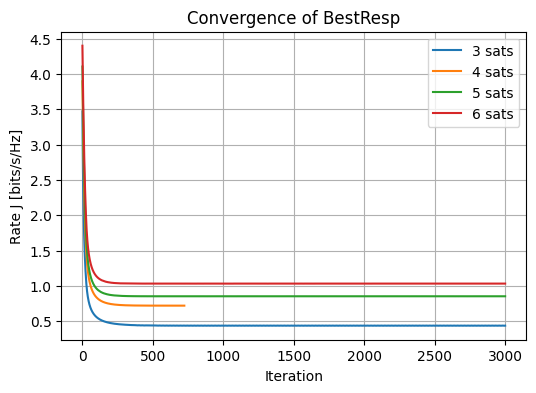

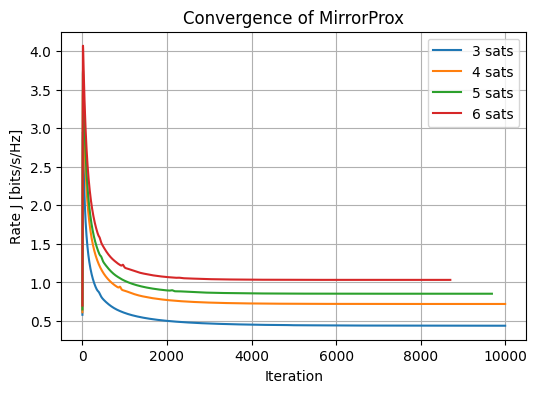

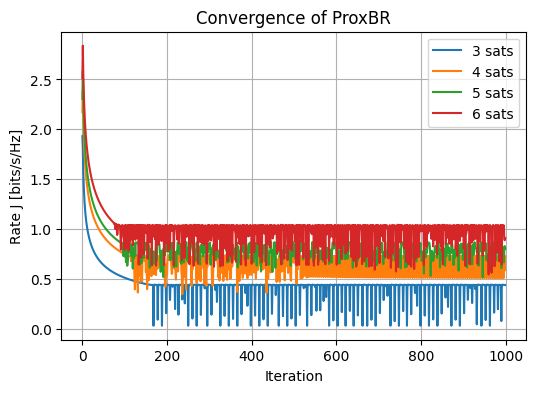

In [12]:

# # -------------------------
# # Plot for convergence
# # -------------------------
for m in methods:
    plt.figure(figsize=(6,4))
    for k in sat_counts:
        hist = results[m][k]
        plt.plot(hist['J'], label=f"{k} sats")
    plt.xlabel("Iteration")
    plt.ylabel("Rate J [bits/s/Hz]")
    plt.title(f"Convergence of {m}")
    plt.legend()
    plt.grid(True)
    plt.show()


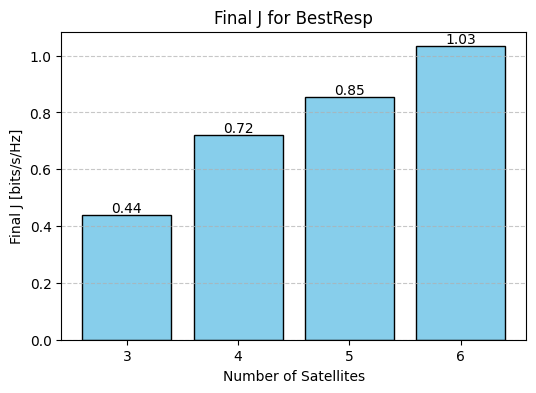

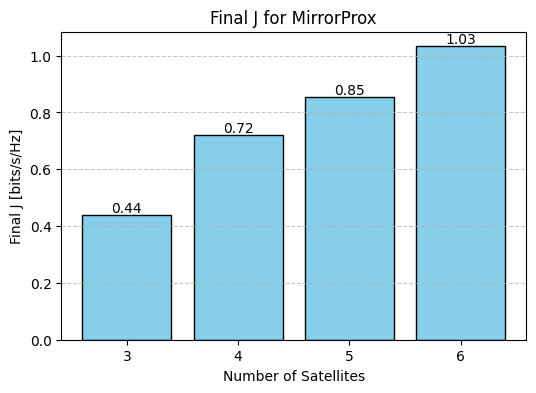

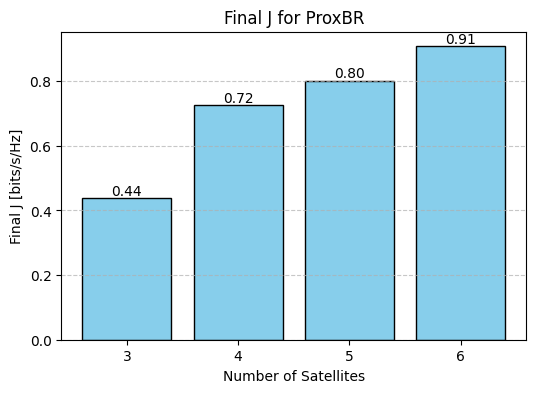

In [13]:
import matplotlib.pyplot as plt
import numpy as np

sat_counts = [3, 4, 5, 6]
methods = ["BestResp", "MirrorProx", "ProxBR"]

for m in methods:
    final_J = [results[m][k]['J'][-1] for k in sat_counts]
    plt.figure(figsize=(6,4))
    plt.bar([str(k) for k in sat_counts], final_J, color="skyblue", edgecolor="k")
    plt.xlabel("Number of Satellites")
    plt.ylabel("Final J [bits/s/Hz]")
    plt.title(f"Final J for {m}")
    for i, v in enumerate(final_J):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
